In [1]:
# install.packages('here')
# install.packages('sf')
# install.packages('janitor')
# install.packages('spatialEco')
# install.packages('gfcanalysis')
# install.packages('geojsonio')

In [2]:
# library(here)
# source(here('init.R'))
# source(here('../nasa-airborne/init.R'))
# library(raster)
library(sf)
library(tidyverse)
###library(janitor)
library(magrittr)
# library(RPostgres)
library(lubridate)
library(fs)
# library(mapview)
library(glue)
library(readxl)
####library(furrr)

# library(fs)
###library(terra)
# library(spatialEco)
# library(gfcanalysis)
# outPath <- path('/explore/nobackup/people/mmacande/srlite/chm_model/20230329_chm')
outPath <- path('/explore/nobackup/people/mmacande/srlite/chm_model/20230515d_chm')
outPath <- path('/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/cnn_chm_model/20230515d_chm')
dir_create(outPath)


Linking to GEOS 3.11.2, GDAL 3.7.0, PROJ 9.2.0; sf_use_s2() is TRUE

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘magrittr’


The following object is masked from ‘package:purrr’:

    set_names


The following object is masked from ‘package:tidyr’:

    extract




Code blocks below are dealing with gdal path issue on adapt. Still needed?

In [3]:
secondPath <- sf_proj_search_paths()[[2]]
secondPath
sf_proj_search_paths(secondPath)

[1] "/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj"

[1] "/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj"

In [4]:
#Reflectance only

# crop_by_bbox <- function(epsg, utmBB, long, lat) {
#     vrt <- rast(path(outPath, glue('alaska-sr-02m_{epsg}_v20221219.vrt')))
#     crop(vrt, utmBB, filename=path(outPath, glue('{epsg}_{long}_{lat}.tif')))
#     }

# pwalk(points_32603 %>% select(epsg, utmBB, long, lat) %>% st_drop_geometry(), crop_by_bbox)

In [5]:
# sf_proj_search_paths('/explore/nobackup/people/mmacande/proj')
dir_ls(sf_proj_search_paths())

/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj/CH
/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj/GL27
/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj/ITRF2000
/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj/ITRF2008
/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj/ITRF2014
/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj/deformation_model.schema.json
/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj/nad.lst
/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj/nad27
/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj/nad83
/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj/other.extra
/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj/proj.db
/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj/proj.ini
/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj/projjson.schema.json
/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj/triangulation.schema.json
/panfs/ccds02/app/modules/jupyter/ilab/R-kernel/share/proj/world

Load point file generated at ABR using SRLite cloud masks eroded (or anti-buffered) by 128 pixel diagonals to ensure all points had full 256x256 chip  

pmm read in : point_overlay_srlite_gliht_buf.gpkg

In [6]:
fires = read_sf('/explore/nobackup/projects/ilab/projects/ABoVE-Shrubs/data/alaska-fire-scars/AlaskaFireHistory_Polygons.gdb') %>% st_transform(4326)
fires$geom = fires$Shape

Warning message in CPL_read_ogr(dsn, layer, query, as.character(options), quiet, :
“GDAL Message 1: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined”


## Bring in points (filtered)
overlaid with extents from:  
1. cloudmasked srlite  
2. gliht  
3. alaska fire polygons

In [38]:
OUTDIR = '/explore/nobackup/people/pmontesa/userfs02/projects/ilab/above_shrubs/data/arc'
foot_intersect_srlite_gliht_buf = read_sf(path(OUTDIR, 'footprints_intersect_srlitevalid_gliht_for_tiles_buf.gpkg')) %>% st_transform(4326)
points_srlite_gliht = read_sf(path(OUTDIR, 'point_overlay_srlite_gliht_buf.gpkg')) %>% st_transform(4326)

## Prep points
1. Get yearDiff between srlite, gliht (this isnt good enough - multiple srlite for gliht, and vice versa  
2. Get fire year  
3. get lat/lon  
4. get utm zone and epsg code info

In [46]:
points_srlite_gliht = points_srlite_gliht %>% 
                        mutate(yearDiff = year_1 - year_2) %>%
                        mutate(YEAR_FIRE = format(as.Date(PERIMETERDATE, format="%Y-%m-%d"),"%Y")) %>%
                        dplyr::mutate(lon = sf::st_coordinates(.)[,1],
                                    lat = sf::st_coordinates(.)[,2]) %>%
                        mutate(epsg = factor(32600 + floor((lon + 180) / 6) + 1)) %>% 
                        mutate(utm = factor(paste0("+init=epsg:", epsg)))

In [47]:
levels(points_srlite_gliht$utm)

[1] "+init=epsg:32605" "+init=epsg:32606" "+init=epsg:32607"

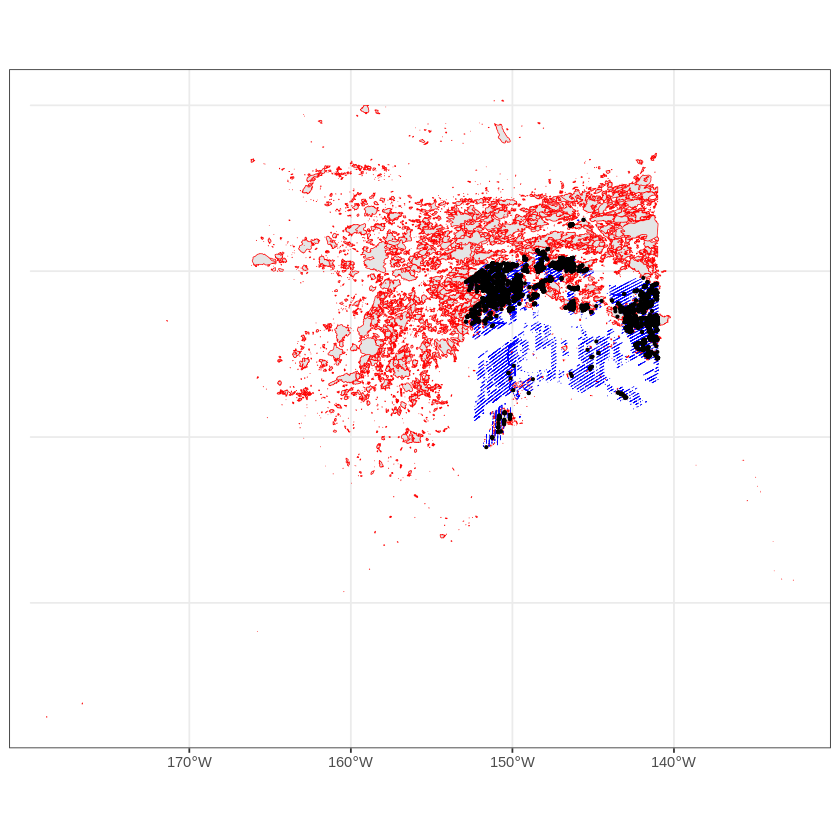

In [48]:
ggplot() + 
    geom_sf(data = fires, color='red') +
    geom_sf(data = foot_intersect_srlite_gliht_buf, color='blue') +
    geom_sf(data = points_srlite_gliht, size=0.5) +
    theme_bw()

In [50]:
head(points_srlite_gliht)

raster_val file_1                                                index year_1
1 0          WV02_20120622_M1BS_103001001AB8DB00-toa.cloudmask.tif NA    2012  
2 0          WV02_20150527_M1BS_10300100429D0200-toa.cloudmask.tif NA    2015  
3 0          WV02_20120622_M1BS_103001001AB8DB00-toa.cloudmask.tif NA    2012  
4 0          WV02_20150527_M1BS_10300100429D0200-toa.cloudmask.tif NA    2015  
5 0          WV02_20120622_M1BS_103001001AB8DB00-toa.cloudmask.tif NA    2012  
6 0          WV02_20150527_M1BS_10300100429D0200-toa.cloudmask.tif NA    2015  
  sensor_1 file_2                                   
1 WV02     AK_20180703_Kenai_FHP1_mosaic_all_p50.tif
2 WV02     AK_20180703_Kenai_FHP1_mosaic_all_p50.tif
3 WV02     AK_20180703_Kenai_FHP1_l0s10_all_p50.tif 
4 WV02     AK_20180703_Kenai_FHP1_l0s10_all_p50.tif 
5 WV02     AK_20180703_Kenai_FHP1_mosaic_all_p50.tif
6 WV02     AK_20180703_Kenai_FHP1_mosaic_all_p50.tif
  path                                                         area_km2
1 /explore/nobackup/people/wcwagne1/data/gliht/_tifs/_unzipped 7.015021
2 /explore/nobackup/people/wcwagne1/data/gliht/_tifs/_unzipped 7.015021
3 /explore/nobackup/people/wcwagne1/data/gliht/_tifs/_unzipped 0.206687
4 /explore/nobackup/people/wcwagne1/data/gliht/_tifs/_unzipped 0.206687
5 /explore/nobackup/people/wcwagne1/data/gliht/_tifs/_unzipped 7.015021
6 /explore/nobackup/people/wcwagne1/data/gliht/_tifs/_unzipped 7.015021
  area_ha  sensor_2 ⋯ FIRESEASONS Shape_Length Shape_Area
1 701.5021 GLiHT    ⋯ 1960 - 1969 159886.3      345221185
2 701.5021 GLiHT    ⋯ 1960 - 1969 159886.3      345221185
3  20.6687 GLiHT    ⋯ 1960 - 1969 159886.3      345221185
4  20.6687 GLiHT    ⋯ 1960 - 1969 159886.3      345221185
5 701.5021 GLiHT    ⋯ 1940 - 1949 417772.6     1287268716
6 701.5021 GLiHT    ⋯ 1940 - 1949 417772.6     1287268716
  geom                       yearDiff YEAR_FIRE lon       lat      epsg 
1 POINT (-150.8125 60.64224) -6       1969      -150.8125 60.64224 32605
2 POINT (-150.8125 60.64224) -3       1969      -150.8125 60.64224 32605
3 POINT (-150.8125 60.64224) -6       1969      -150.8125 60.64224 32605
4 POINT (-150.8125 60.64224) -3       1969      -150.8125 60.64224 32605
5 POINT (-150.7902 60.58214) -6       1947      -150.7902 60.58214 32605
6 POINT (-150.7902 60.58214) -3       1947      -150.7902 60.58214 32605
  utm             
1 +init=epsg:32605
2 +init=epsg:32605
3 +init=epsg:32605
4 +init=epsg:32605
5 +init=epsg:32605
6 +init=epsg:32605

In [51]:
#points_srlite_gliht %>% st_drop_geometry() %>% group_by(mm) %>% tally()
points_srlite_gliht %>% st_drop_geometry() %>% group_by(YEAR_FIRE) %>% tally()
points_srlite_gliht %>% st_drop_geometry() %>% group_by(yearDiff) %>% tally()

YEAR_FIRE,n
<chr>,<int>
1942,1
1944,2
1946,2
1947,36
1948,3
1950,10
1951,128
1953,18
1954,27


yearDiff,n
<dbl>,<int>
-10,2
-8,106
-7,2
-6,4
-4,165
-3,161
-2,229
-1,185
0,947


In [4]:
# import os; os.environ['PROJ_LIB'] = '/home/mmacande/.conda/envs/r4-base-20230102/share/proj'
# proj error fix above, below did not work
# cp -r /home/mmacande/.conda/envs/r4-base-20230102/share/proj /explore/nobackup/people/mmacande/proj

# points <- read_sf('/explore/nobackup/people/mmacande/srlite/chm_model/chm_sample_100k_chm_1kPerBin_p1_v20230329.csv') %>%
points <- read_sf('/explore/nobackup/people/mmacande/srlite/chm_model/ifsarChm_x_srlite_alaska_v20230401.csv') %>%
st_as_sf(coords=c('long','lat'), crs=4326, agr="constant", remove=F) %>%
mutate(epsg = as.integer(epsg))

print(points %>% group_by(epsg) %>% tally())
head(points)

although coordinates are longitude/latitude, st_union assumes that they are planar
although coordinates are longitude/latitude, st_union assumes that they are planar
although coordinates are longitude/latitude, st_union assumes that they are planar
although coordinates are longitude/latitude, st_union assumes that they are planar
although coordinates are longitude/latitude, st_union assumes that they are planar


Simple feature collection with 5 features and 2 fields
Geometry type: MULTIPOINT
Dimension:     XY
Bounding box:  xmin: -166.0372 ymin: 56.58549 xmax: -140.8615 ymax: 71.01012
Geodetic CRS:  WGS 84
# A tibble: 5 × 3
   epsg      n                                                          geometry
  <int>  <int>                                                  <MULTIPOINT [°]>
1 32603 131916 ((-166.0372 65.56413), (-166.0371 65.51273), (-166.0363 65.58756…
2 32604 249568 ((-162 62.99359), (-162 65.62792), (-162 62.26927), (-161.9999 6…
3 32605 242088 ((-156 60.3347), (-156 66.57936), (-156 64.28936), (-156 62.7669…
4 32606 315967 ((-150 69.46897), (-150 62.50546), (-149.9999 61.97332), (-149.9…
5 32607  77446 ((-144 64.10774), (-143.9999 68.1593), (-143.9999 68.83919), (-1…


Warning message in fun(libname, pkgname):
“rgeos: versions of GEOS runtime 3.9.1-CAPI-1.14.2
and GEOS at installation 3.9.1dev-CAPI-1.14.1differ”Registered S3 method overwritten by 'geojsonsf':
  method        from   
  print.geojson geojson


FID_fishnet_512m_label,FID_Alaska_srlite_fp_detailed_buff_minus362m,utm,epsg,baseName,year,mm,dd,sensor,granuleID,geometry,...,created_us,created_da,last_edite,last_edi_1,Shape__Are,Shape__Len,yearDiff,lat,long,geometry
755,9,+init=epsg:32604,32604,GE01_20180908_M1BS_105001001217FE00,2018,9,8,GE01,105001001217FE00,POINT (-158.0003 56.58549),...,NA,NA,NA,NA,NA,NA,NA,56.58549100730233,-158.0002740246949,POINT (-158.0003 56.58549)
756,9,+init=epsg:32604,32604,GE01_20180908_M1BS_105001001217FE00,2018,9,8,GE01,105001001217FE00,POINT (-157.9919 56.58577),...,NA,NA,NA,NA,NA,NA,NA,56.585767006198346,-157.99194129711498,POINT (-157.9919 56.58577)
757,9,+init=epsg:32604,32604,GE01_20180908_M1BS_105001001217FE00,2018,9,8,GE01,105001001217FE00,POINT (-157.9836 56.58604),...,NA,NA,NA,NA,NA,NA,NA,56.586042430179475,-157.98360844368952,POINT (-157.9836 56.58604)
758,9,+init=epsg:32604,32604,GE01_20180908_M1BS_105001001217FE00,2018,9,8,GE01,105001001217FE00,POINT (-157.9753 56.58632),...,NA,NA,NA,NA,NA,NA,NA,56.586317279233185,-157.97527546467805,POINT (-157.9753 56.58632)
759,9,+init=epsg:32604,32604,GE01_20180908_M1BS_105001001217FE00,2018,9,8,GE01,105001001217FE00,POINT (-157.9669 56.58659),...,NA,NA,NA,NA,NA,NA,NA,56.586591553347134,-157.96694236034017,POINT (-157.9669 56.58659)
760,9,+init=epsg:32604,32604,GE01_20180908_M1BS_105001001217FE00,2018,9,8,GE01,105001001217FE00,POINT (-157.9586 56.58687),...,NA,NA,NA,NA,NA,NA,NA,56.586865252508794,-157.95860913093537,POINT (-157.9586 56.58687)


In [5]:
#ggplot(points) + geom_sf()

In [11]:
# gdal(lib='all')
# file_info('/home/mmacande/.conda/envs/r4-base-20230102/share/proj/proj.db')
# dir_ls('/home/mmacande/.conda/envs/r4-base-20230102/share/proj')
# read_csv('/home/mmacande/.conda/envs/r4-base-20230102/share/proj/proj.ini')

In [6]:
# points %>% st_drop_geometry()
# points$mm
points %>% st_drop_geometry() %>% group_by(mm) %>% tally()
points %>% st_drop_geometry() %>% group_by(fireFlag) %>% tally()
points %>% st_drop_geometry() %>% group_by(yearDiff) %>% tally()

mm,n
5,73554
6,366706
7,167007
8,171823
9,237895


fireFlag,n
FALSE,957426
NA,38593
TRUE,20966


yearDiff,n
-1,56110
-2,62825
-3,82930
-4,13609
-6,13874
-7,7520
-8,14827
0,86061
1,123880
10,124


Filter points to include only July/August, exclude points with very recent fire or fire between image and ifsar acquisition, and points with > 3 years between image and ifsar acquisition.

In [7]:
filtered_points <- points %>%
dplyr::filter(between(mm, 7, 8),
       fireFlag == 'FALSE',
       between(as.integer(yearDiff), -3, 3)) %>%
mutate(trainValTest = case_when(
    random < 0.45 ~ 'train',
    random < 0.90 ~ 'val',
    T ~ 'test'))

filtered_points %>% st_drop_geometry() %>% group_by(trainValTest) %>% tally()

# filtered_points %>% st_drop_geometry()
nrow(points)
nrow(filtered_points)

Warning message in between(as.integer(yearDiff), -3, 3):
“NAs introduced by coercion”

trainValTest,n
test,19603
train,85478
val,85132


[1] 1016985

[1] 190213

In [41]:
filtered_points_rebal_sqrt <- filtered_points %>%
  mutate(chm_mean_dm_i = as.integer(chm_mean_dm_i)) %>%
  filter(!is.na(chm_mean_dm_i)) %>%
  # filter(trainValTest %in% c('train','val')) %>%
  group_by(chm_mean_dm_i) %>%
  mutate(n = n(),
         freq = n / sum(n),
         sqrt_n = sqrt(n),
         swrt_freq = sqrt_n / sum(sqrt_n)) %>%
  ungroup() %>%
  # slice_sample(n=33333, weight_by=1/sqrt_n)
  slice_sample(n=33333, weight_by=1/sqrt_n)

sqrtByChm <- filtered_points_rebal_sqrt %>%
  st_drop_geometry() %>%
  group_by(chm_mean_dm_i) %>%
  summarize(n = n()) %>%
  mutate(freq = n / sum(n))

sqrtByTrainTest <- filtered_points_rebal_sqrt %>%
  st_drop_geometry() %>%
  group_by(trainValTest) %>%
  tally()

sqrtByBaseName <- filtered_points_rebal_sqrt %>%
  st_drop_geometry() %>%
  group_by(baseName) %>%
  tally()

# mapview(filtered_points_rebal_sqrt, zcol='chm_mean_dm_i')
# mapview(filtered_points_rebal_sqrt %>% select(trainValTest), zcol='trainValTest')

trainLte1mCHM <- filtered_points_rebal_sqrt %>%
  filter(chm_mean_dm_i <= 10)
# mapview(trainLte1mCHM %>% select(chm_mean_dm_i), zcol='chm_mean_dm_i')

write_csv(filtered_points_rebal_sqrt %>% st_drop_geometry(), 
          path(outPath, 'ifsarChm_x_srlite_alaska_v20230401_filt78_33k.csv'))
       
# nrow(filtered_points_train)

# filtered_points_train %>% st_drop_geometry() %>% group_by(epsg) %>% tally()

In [42]:
# filtered_points %>% st_drop_geometry()
filtered_points_rebal_sqrt %>% colnames()
filtered_points_rebal_sqrt %>% st_drop_geometry() %>% group_by(chm_mean_dm_i) %>% mutate(chm_mean_dm_i = as.integer(chm_mean_dm_i)) %>% tally() %>%
write_csv(path(outPath, 'ifsarChm_x_srlite_alaska_v20230401_filt78_33k_chm_mean_dm_i_summary.csv'))



[1] "FID_fishnet_512m_label"                      
 [2] "FID_Alaska_srlite_fp_detailed_buff_minus362m"
 [3] "utm"                                         
 [4] "epsg"                                        
 [5] "baseName"                                    
 [6] "year"                                        
 [7] "mm"                                          
 [8] "dd"                                          
 [9] "sensor"                                      
[10] "granuleID"                                   
[11] "chip_gran_id"                                
[12] "random"                                      
[13] "chipName"                                    
[14] "chm_mean"                                    
[15] "chm_mean_dm_i"                               
[16] "ifsar_year"                                  
[17] "fireYear_minus_imageYear"                    
[18] "fireYear_minus_ifsarYear"                    
[19] "fireFlag"                                    
[20] "mrfy_min"                                    
[21] "mrfy_max"                                    
[22] "Name"                                        
[23] "MinPS"                                       
[24] "MaxPS"                                       
[25] "LowPS"                                       
[26] "HighPS"                                      
[27] "Category"                                    
[28] "Tag"                                         
[29] "GroupName"                                   
[30] "ProductName"                                 
[31] "CenterX"                                     
[32] "CenterY"                                     
[33] "ZOrder"                                      
[34] "TypeID"                                      
[35] "ItemTS"                                      
[36] "UriHash"                                     
[37] "BUFF_DIST"                                   
[38] "ORIG_FID"                                    
[39] "cell"                                        
[40] "status"                                      
[41] "date_start"                                  
[42] "date_end"                                    
[43] "date_pub"                                    
[44] "collector"                                   
[45] "sq_miles"                                    
[46] "task_order"                                  
[47] "globalid"                                    
[48] "created_us"                                  
[49] "created_da"                                  
[50] "last_edite"                                  
[51] "last_edi_1"                                  
[52] "Shape__Are"                                  
[53] "Shape__Len"                                  
[54] "yearDiff"                                    
[55] "lat"                                         
[56] "long"                                        
[57] "geometry"                                    
[58] "trainValTest"                                
[59] "n"                                           
[60] "freq"                                        
[61] "sqrt_n"                                      
[62] "swrt_freq"

In [43]:
#Don't rebalance for test set
filtered_points_test <- filtered_points %>%
  mutate(chm_mean_dm_i = as.integer(chm_mean_dm_i)) %>%
  filter(!is.na(chm_mean_dm_i)) %>%
  filter(trainValTest %in% c('test')) %>%
  ungroup() %>%
  slice_sample(n=5000)

# mapview(filtered_points_test %>% select(chm_mean_dm_i), zcol='chm_mean_dm_i')

nrow(filtered_points_test)

testByChm <- filtered_points_test %>%
  st_drop_geometry() %>%
  group_by(chm_mean_dm_i) %>%
  summarize(n = n()) %>%
  mutate(freq = n / sum(n))

testByChm
write_csv(filtered_points_test %>% st_drop_geometry(), 
          path(outPath, 'ifsarChm_x_srlite_alaska_v20230401_filt78_5k_test_noBal.csv'))


[1] 5000

chm_mean_dm_i,n,freq
<int>,<int>,<dbl>
0,3052,0.6104
1,275,0.0550
2,108,0.0216
3,88,0.0176
4,78,0.0156
5,60,0.0120
6,50,0.0100
7,49,0.0098
8,43,0.0086


#slice_sample hacky fix

https://github.com/tidyverse/dplyr/issues/6185#issuecomment-1330766323

@erydit FWIW if you need this right away and can't install the dev package, this is pretty easy to "patch" by redefining dplyr:::sample_int with the code below. This is of course a bad idea in general, but may be useful as a temporary fix for development while waiting for the new release.

I should probably mention I don't work at Rstudio and this hacky patch is not recommended by them I'd guess :)



In [44]:

# sample_int <- function(n, size, replace = FALSE, wt = NULL, call = caller_env()) {
#   if (!replace && n < size) {
#    size <- n
#   }

#   if (size == 0L) {
#     integer(0)
#   } else {
#     sample.int(n, size, prob = wt, replace = replace)
#   }
# }

# assignInNamespace('sample_int', sample_int, 'dplyr')


In [45]:
# filtered_points_rebal <- filtered_points %>%
#   mutate(chm_mean_dm_i = as.integer(chm_mean_dm_i)) %>%
#   group_by(chm_mean_dm_i) %>%
#   slice_sample(n=500)

# filtered_points_rebal %>% st_drop_geometry() %>% group_by(chm_mean_dm_i) %>% mutate(chm_mean_dm_i = as.integer(chm_mean_dm_i)) %>% tally()
nrow(filtered_points_rebal_sqrt)

filtered_points_train <- filtered_points_rebal_sqrt %>%
    filter(trainValTest %in% c('train','val'))

filtered_points_train %>% st_drop_geometry() %>% group_by(epsg) %>% tally()

nrow(filtered_points_train)


[1] 33333

epsg,n
<int>,<int>
32603,1973
32604,16730
32605,1280
32606,9638
32607,300


[1] 29921

Turn sample points into 256x256 pixel bounding box in approrpriate UTM zone

In [46]:
# plot(points)

# point <- head(points %>% filter(epsg==32606), n=2)
# point %>% st_drop_geometry()
# point_bb <- point %>%

# points_32603 <- points %>%
# filter(epsg == 32603) %>%
# rowwise() %>%
# mutate(utmPoint = st_transform(geometry, epsg),
#        utmBuff = st_buffer(utmPoint, 256),
#        utmBB = st_as_sfc(st_bbox(utmBuff)))

points_bbox_epsg <- function(epsgCode, points) {
    points_epsg <- points %>%
    filter(epsg == epsgCode) %>%
    rowwise() %>%
    mutate(utmPoint = st_transform(geometry, epsgCode),
           utmBuff = st_buffer(utmPoint, 256),
           utmBB = st_as_sfc(st_bbox(utmBuff)))
    }

In [47]:
print(32603)
points_32603 <- points_bbox_epsg(32603, filtered_points_train)
print(32604)
points_32604 <- points_bbox_epsg(32604, filtered_points_train)
print(32605)
points_32605 <- points_bbox_epsg(32605, filtered_points_train)
print(32606)
points_32606 <- points_bbox_epsg(32606, filtered_points_train)
print(32607)
points_32607 <- points_bbox_epsg(32607, filtered_points_train)
# points_32608 <- points_bbox_epsg(32608, points)
# points_32609 <- points_bbox_epsg(32609, points)
   
# plot(points_32607$utmBB)
# str(points_32603)

[1] 32603
[1] 32604
[1] 32605
[1] 32606
[1] 32607


In [48]:
# filtered_points_test <- filtered_points_rebal_sqrt %>%
#     filter(trainValTest == 'test') %>%
#     slice_sample(n=5000)
       
nrow(filtered_points_test)

filtered_points_test %>% st_drop_geometry() %>% group_by(epsg) %>% tally()


[1] 5000

epsg,n
<int>,<int>
32603,262
32604,1898
32605,360
32606,2437
32607,43


In [49]:
print(32603)
points_32603_test <- points_bbox_epsg(32603, filtered_points_test)
print(32604)
points_32604_test <- points_bbox_epsg(32604, filtered_points_test)
print(32605)
points_32605_test <- points_bbox_epsg(32605, filtered_points_test)
print(32606)
points_32606_test <- points_bbox_epsg(32606, filtered_points_test)
print(32607)
points_32607_test <- points_bbox_epsg(32607, filtered_points_test)


[1] 32603
[1] 32604
[1] 32605
[1] 32606
[1] 32607


Get list of SRLite scenes

In [50]:
alaska_2m <- path('/explore/nobackup/people/mmacande/srlite/srlite_ilab_data_srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Alaska')
dir_ls(alaska_2m, glob='*sr-02m.tif') %>%
head()

# rast <- rast(path(alaska_2m, 'GE01_20140705_M1BS_1050410010CD1600-sr-02m.tif'))
# # nlyr(rast)
# rast
# crs(rast, describe=T)$code

rast_df <- tibble(
    # rastPath = dir_ls(alaska_2m, glob='*noncog.tif')) %>%
    rastPath = dir_ls(alaska_2m, glob='*sr-02m.tif')) %>%
rowwise() %>%
mutate(nlyr = nlyr(rast(rastPath)),
      epsg = crs(rast(rastPath), describe=T)$code)

rast_df %>%
group_by(epsg) %>%
tally()


/explore/nobackup/people/mmacande/srlite/srlite_ilab_data_srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Alaska/GE01_20140705_M1BS_1050410010CD1600-sr-02m.tif
/explore/nobackup/people/mmacande/srlite/srlite_ilab_data_srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Alaska/GE01_20150731_M1BS_1050010001163300-sr-02m.tif
/explore/nobackup/people/mmacande/srlite/srlite_ilab_data_srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Alaska/GE01_20160801_M1BS_105001000598DB00-sr-02m.tif
/explore/nobackup/people/mmacande/srlite/srlite_ilab_data_srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Alaska/GE01_20160903_M1BS_1050010006273D00-sr-02m.tif
/explore/nobackup/people/mmacande/srlite/srlite_ilab_data_srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Alaska/GE01_20180611_M1BS_1050010010757600-sr-02m.tif
/explore/nobackup/people/mmacande/srlite/srlite_ilab_data_srlite/products/srlite-0.9.15-10282022-qa/10282022-all/Alaska/GE01_20180822_M1BS_1050010011B34400-sr-02m.tif

epsg,n
<chr>,<int>
32603,19
32604,35
32605,37
32606,59
32607,13
32608,7
32609,2


In [51]:
# rast_df

In [52]:
# rast_vrt_epsg <- function(epsgCode, rast_df, outPath) {
#     vrt((rast_df %>% filter(epsg == epsgCode))$rastPath, path(outPath, glue('alaska-sr-02m_{epsgCode}_v20221219.vrt')), overwrite=T)
# }

# seq(32603,32609)
# vrts <- walk(seq(32603,32609), rast_vrt_epsg, rast_df=rast_df, outPath=outPath)

In [53]:
r <- rast(ncols=10, nrows=10)
values(r) <- 1:ncell(r)
global(r, "sum")[[1]]
# global(r, "mean", na.rm=TRUE)
# x <- c(r, r/10)
# global(x, c("sum", "mean", "sd"), na.rm=TRUE)

[1] 5050

Function to Load SRLite, IFSAR DSM/DTM/CHM and crop by bounding box
Save out to image and label geotiffs

In [58]:
#Reflectance + DEM
# ned <- rast('/explore/nobackup/projects/dem/alaskaned_mosaic_wgs84.tif')
ifsar_dtm <- rast('/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_dtm_20221222.tif')
ifsar_dsm <- rast('/explore/nobackup/projects/dem/AK_IFSAR/alaska_ifsar_dsm_20221222.tif')

crop_by_bbox2_chm <- function(epsg, utmBB, baseName, chipName, outPrefix) {
    sr_2m_strip <- rast(path(alaska_2m, glue('{baseName}-sr-02m.tif')))
    sr_2m <- crop(sr_2m_strip, utmBB)#, filename=path(outPath, glue('{epsg}_{long}_{lat}.tif')))
    names(sr_2m) <- c('01_blue','02_green','03_red','04_nir')
    dtm_2m <- project(ifsar_dtm, sr_2m, method='bilinear')
    dsm_2m <- project(ifsar_dsm, sr_2m, method='bilinear')
    chm_2m <- dsm_2m - dtm_2m
    chm_2m_clamp <- clamp(chm_2m, 0.0000001, 10000)
    chm_dm_2m <- round(chm_2m_clamp * 10)
    
    # phys_2m <- project(phys, sr_2m, method='near')
    # names(dem_2m) <- c('05_elev_m')
    names(dtm_2m) <- c('05_dtm_m')
    names(chm_2m) <- c('06_chm_m')

    chm_sum = global(chm_dm_2m, 'sum')[[1]]
    if(chm_sum > 0) {   
        predictor_stack_2m <- c(sr_2m, dtm_2m)
        writeRaster(predictor_stack_2m, filename=path(outPath, glue('{outPrefix}_images'), glue('{chipName}.tif')), overwrite=T)
        label_stack_2m <- c(chm_dm_2m)
        writeRaster(label_stack_2m, filename=path(outPath, glue('{outPrefix}_labels'), glue('{chipName}.tif')), overwrite=T)
        } else {
        print(glue('{chipName} is all zero canopy height, not exported')) }
    return(baseName)
}

dir_create(path(outPath, 'train_images'))
dir_create(path(outPath, 'train_labels'))

dir_create(path(outPath, 'test_images'))
dir_create(path(outPath, 'test_labels'))


In [ ]:
points_32603 %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry() %>% ungroup() %>% slice_head(n=2)

In [59]:
class(points_32603)
plan(multicore, workers=30)

[1] "sf"         "rowwise_df" "tbl_df"     "tbl"        "data.frame"

In [63]:
plan()

multicore:
- args: function (..., workers = 30, envir = parent.frame())
- tweaked: TRUE
- call: plan(multicore, workers = 30)

In [ ]:
pwalk(points_32603 %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry() %>% ungroup() %>% slice_head(n=2), crop_by_bbox2_chm, 'train')

In [ ]:
points_32603_test %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry() %>% ungroup() %>% slice_head(n=2)

In [ ]:
# pwalk(points_32603_test %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry() %>% ungroup() %>% slice_head(n=2), crop_by_bbox2_chm, 'test')
pwalk(points_32603_test %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry() %>% ungroup(), crop_by_bbox2_chm, 'test')

Generate all the image and label chips (batched up by UTM zone)

In [ ]:

# # crop_by_bbox2(
# print(32603)
# pwalk(points_32603 %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'train')
# pwalk(points_32603_test %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'test')
# print(32604)
# pwalk(points_32604 %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'train')
# pwalk(points_32604_test %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'test')
# print(32605)
# pwalk(points_32605 %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'train')
# pwalk(points_32605_test %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'test')
# print(32606)
# pwalk(points_32606 %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'train')
# pwalk(points_32606_test %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'test')
# print(32607)
# pwalk(points_32607 %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'train')
# pwalk(points_32607_test %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'test')
# # print(32608)
# # pwalk(points_32608 %>% select(epsg, utmBB, baseName, long, lat) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL))
# # print(32609)
# # pwalk(points_32609 %>% select(epsg, utmBB, baseName, long, lat) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL))

In [64]:
print(32603)
future_pwalk(points_32603 %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry() %>% ungroup(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'train')
future_pwalk(points_32603_test %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry() %>% ungroup(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'test')
print(32604)
future_pwalk(points_32604 %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'train')
future_pwalk(points_32604_test %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'test')
print(32605)
future_pwalk(points_32605 %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'train')
future_pwalk(points_32605_test %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'test')
print(32606)
future_pwalk(points_32606 %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'train')
future_pwalk(points_32606_test %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'test')
print(32607)
future_pwalk(points_32607 %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'train')
future_pwalk(points_32607_test %>% select(epsg, utmBB, baseName, chipName) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL), 'test')


[1] 32603


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

chip_WV02_20130818_M1BS_10300100269C9900_02672_v20230331_32603 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

chip_WV02_20130818_M1BS_10300100269C9900_00033_v20230331_32603 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

chip_WV02_20130818_M1BS_10300100269C9900_01625_v20230331_32603 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

chip_WV02_20130818_M1BS_10300100269C9900_02746_v20230331_32603 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

[1] 32604


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

chip_WV02_20160816_M1BS_103001005BCAAD00_05363_v20230331_32604 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20160816_M1BS_103001005BCAAD00_05260_v20230331_32604 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

[1] 32605


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

[1] 32606
chip_WV02_20140714_M1BS_10300100330BCE00_05334_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_03267_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_02070_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_01752_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_02447_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_03201_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_05398_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_01650_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_01683_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_03396_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_05209_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_05274_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_03276_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_01193_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_00729_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_05690_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_01860_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_00666_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_05311_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_01929_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_01986_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_00605_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_05865_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20110819_M1BS_103001000DC1B400_07535_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_01722_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_01062_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20110819_M1BS_103001000DC1B400_06451_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_02588_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_05915_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_00872_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_05730_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_01956_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_05707_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_03194_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_05340_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_01710_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_05818_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_03074_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_05426_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_03265_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_02088_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_05889_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_02750_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_05896_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_00726_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_05406_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_05366_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_02056_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_05879_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_01807_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_01168_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_00082_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_03911_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_02555_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_02211_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_05368_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_02558_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_01611_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_01845_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_02054_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_05858_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_05246_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_03294_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_05268_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_05431_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_00785_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_05401_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_01776_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

chip_WV02_20140714_M1BS_10300100330BCE00_05893_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_01871_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_01609_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_01932_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_03098_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_00846_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_00032_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_01684_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_05736_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_01912_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_01833_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

chip_WV02_20140714_M1BS_10300100330BCE00_01747_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_01630_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_01167_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

chip_WV02_20140714_M1BS_10300100330BCE00_01847_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_05409_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_02305_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_02303_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_01191_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

chip_WV02_20140714_M1BS_10300100330BCE00_05277_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_01580_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_05812_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


chip_WV02_20140714_M1BS_10300100330BCE00_05773_v20230331_32606 is all zero canopy height, not exported
chip_WV02_20140714_M1BS_10300100330BCE00_00756_v20230331_32606 is all zero canopy height, not exported


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”


[1] 32607


Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated random numbers without specifying argument 'seed'. There is a risk that those random numbers are not statistically sound and the overall results might be invalid. To fix this, specify 'seed=TRUE'. This ensures that proper, parallel-safe random numbers are produced via the L'Ecuyer-CMRG method. To disable this check, use 'seed=NULL', or set option 'future.rng.onMisuse' to "ignore".”
Warning message:
“UNRELIABLE VALUE: Future (‘<none>’) unexpectedly generated

In [65]:
# outPath <- path('/explore/nobackup/people/mmacande/srlite/phys_model/20230329_chm')
# dir_create(outPath)
# dir_create(path(outPath, 'images'))
# dir_create(path(outPath, 'labels'))

# rast_vrt_epsg <- function(epsgCode, rast_df, outPath) {
#     vrt((rast_df %>% filter(epsg == epsgCode))$rastPath, path(outPath, glue('alaska-sr-02m_{epsgCode}_v20221219.vrt')), overwrite=T)
# }

# seq(32603,32609)
# vrts <- walk(seq(32603,32609), rast_vrt_epsg, rast_df=rast_df, outPath=outPath)

# crop_by_bbox2_chm <- function(epsg, utmBB, long, lat) {
#     vrt <- rast(path(outPath, glue('alaska-sr-02m_{epsg}_v20221219.vrt')))
#     sr_2m <- crop(vrt, utmBB)#, filename=path(outPath, glue('{epsg}_{long}_{lat}.tif')))
#     names(sr_2m) <- c('01_blue','02_green','03_red','04_nir')
#     dtm_2m <- project(ifsar_dtm, sr_2m, method='bilinear')
#     dsm_2m <- project(ifsar_dsm, sr_2m, method='bilinear')
#     chm_2m <- dsm_2m - dtm_2m
#     chm_dm_2m <- clamp(round(chm_2m * 10),0,1000)
#     # phys_2m <- project(phys, sr_2m, method='near')
#     # names(dem_2m) <- c('05_elev_m')
#     names(dtm_2m) <- c('05_dtm_m')
#     names(chm_2m) <- c('06_chm_m')
#     # names(phys_2m) <- c('07_phys_code')
#     # stack_2m <- c(sr_2m, dtm_2m, chm_2m, phys_2m)
#     # writeRaster(stack_2m, filename=path(outPath, glue('{epsg}_{long}_{lat}.tif')), overwrite=T)
#     # predictor_stack_2m <- c(sr_2m, dtm_2m)
#     predictor_stack_2m <- c(sr_2m)
#     writeRaster(predictor_stack_2m, filename=path(outPath, 'images', glue('{epsg}_{long}_{lat}.tif')), overwrite=T)
#     label_stack_2m <- c(chm_dm_2m)
#     writeRaster(label_stack_2m, filename=path(outPath, 'labels', glue('{epsg}_{long}_{lat}.tif')), overwrite=T)
# }


In [66]:
# pwalk(points_32603 %>% select(epsg, utmBB, long, lat) %>% st_drop_geometry() %>% ungroup() %>% slice_head(n=2), crop_by_bbox2_chm)

In [67]:

# # crop_by_bbox2(
# pwalk(points_32603 %>% select(epsg, utmBB, long, lat) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL))
# pwalk(points_32604 %>% select(epsg, utmBB, long, lat) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL))
# pwalk(points_32605 %>% select(epsg, utmBB, long, lat) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL))
# pwalk(points_32606 %>% select(epsg, utmBB, long, lat) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL))
# pwalk(points_32607 %>% select(epsg, utmBB, long, lat) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL))
# # pwalk(points_32608 %>% select(epsg, utmBB, long, lat) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL))
# # pwalk(points_32609 %>% select(epsg, utmBB, long, lat) %>% st_drop_geometry(), possibly(crop_by_bbox2_chm, otherwise=NULL))

Make it all readable by others

In [68]:
file_chmod(dir_ls(outPath, recurse=T), mode='755')
# file_chmod(dir_ls('/explore/nobackup/people/mmacande/srlite/phys_model/20230131_phys', recurse=T), mode='755')


In [69]:
outPath


/explore/nobackup/people/mmacande/srlite/chm_model/20230515d_chm